In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

## Simulate dataset and information footprint

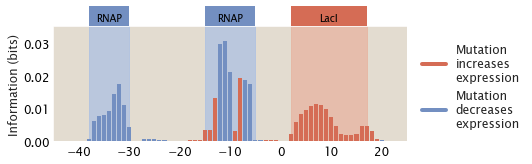

In [8]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 1
N = len(genome)

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                        *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35)

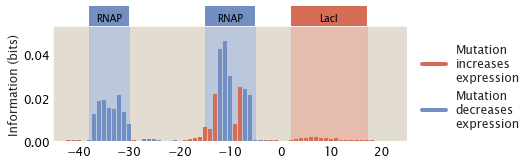

In [9]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 50
N = len(genome)

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                        *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35)

In [6]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
l_M = np.arange(1, 200, 1)
N = len(genome)

signal_rep = []

for M in l_M:
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                        *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0])

    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
    signal_rep.append(np.mean(footprint[(2+115):(17+116)]))

Text(0, 0.5, 'Average signal at repressor binding site')

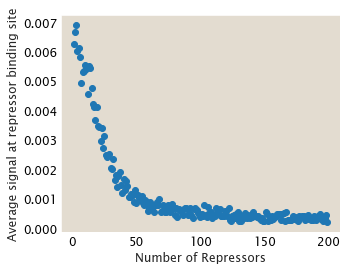

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(l_M, signal_rep)
ax.set_xlabel('Number of Repressors')
ax.set_ylabel('Average signal at repressor binding site')